<a href="https://colab.research.google.com/github/codrae/timeseries-dl-models/blob/main/AMPds2_processed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [79]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from torch.utils.data import DataLoader, Dataset, random_split, Subset
import matplotlib.pyplot as plt
import os
import random

In [80]:
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/Electricity_B2E.csv')
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,unix_ts,V,I,f,DPF,APF,P,Pt,Q,Qt,S,St
0,1333263600,118.0,0.5,60.0,1.00,0.98,58,16640,2,2037,59,28157
1,1333263660,118.0,0.5,60.0,1.00,0.98,58,16641,2,2037,59,28158
2,1333263720,117.8,0.1,60.0,0.96,0.55,8,16642,2,2037,15,28159
3,1333263780,118.0,0.1,60.0,0.96,0.52,7,16642,2,2037,15,28159
4,1333263840,118.2,0.1,60.0,0.98,0.56,8,16642,1,2037,14,28159


In [81]:
import pandas as pd
df['date'] = pd.to_datetime(df['unix_ts'], unit='s')
df = df.set_index('date')
df = df[['P']]

num_rows = len(df)
num_zeros = (df['P'] == 0).sum()
zero_percentage = (num_zeros / num_rows) * 100

num_missing = df['P'].isnull().sum()

print(f"전체 행의 수: {num_rows}")
print(f"0값의 개수: {num_zeros}")
print(f"0값의 비율: {zero_percentage:.2f}%")
print(f"결측치 수: {num_missing}")


전체 행의 수: 1051200
0값의 개수: 19538
0값의 비율: 1.86%
결측치 수: 0


In [82]:
import numpy as np
# 0값을 NaN으로 대체
df['P'] = df['P'].replace(0, np.nan)

# 선형 보간법 적용
df['P'] = df['P'].interpolate(method='linear')

# 다시 상태 체크
p_column = df['P']
num_zeros = (p_column == 0).sum()
total_rows = len(p_column)
zero_ratio = num_zeros / total_rows
num_missing = p_column.isnull().sum()

print(f"0값 개수: {num_zeros}")
print(f"전체 행 개수: {total_rows}")
print(f"0값 비율: {zero_ratio:.4f}")
print(f"결측치 개수: {num_missing}")


0값 개수: 0
전체 행 개수: 1051200
0값 비율: 0.0000
결측치 개수: 0


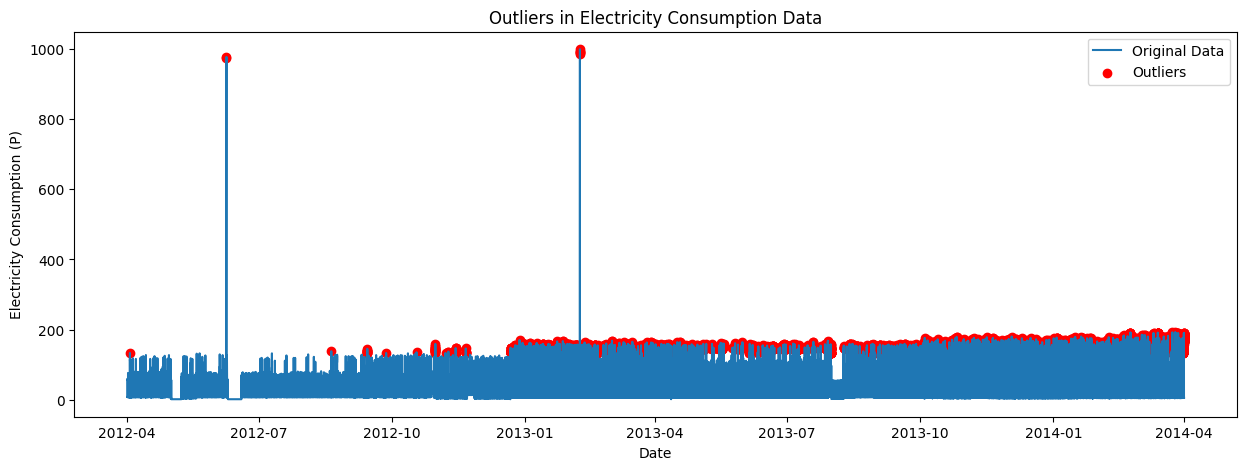

                            P
date                         
2012-04-01 07:00:00  9.516667
2012-04-01 08:00:00  7.466667
2012-04-01 09:00:00  7.316667
2012-04-01 10:00:00  7.416667
2012-04-01 11:00:00  7.500000
                             P
date                          
2014-04-01 02:00:00   5.000000
2014-04-01 03:00:00  60.382270
2014-04-01 04:00:00  63.569149
2014-04-01 05:00:00  39.340248
2014-04-01 06:00:00   5.000000


In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Z-score 계산
df['z_score'] = (df['P'] - df['P'].mean()) / df['P'].std()

# Z-score가 3 초과인 데이터 확인
outliers = df[df['z_score'] > 3]

# 이상치 시각화
plt.figure(figsize=(15, 5))
plt.plot(df['P'], label='Original Data')
plt.scatter(outliers.index, outliers['P'], color='red', label='Outliers')
plt.legend()
plt.title('Outliers in Electricity Consumption Data')
plt.xlabel('Date')
plt.ylabel('Electricity Consumption (P)')
plt.show()


# 이상치를 NaN으로 대체
df.loc[df['z_score'] > 3, 'P'] = np.nan

# 선형 보간법으로 이상치 처리
df['P'] = df['P'].interpolate(method='linear')

# 1시간 단위로 데이터 샘플링
df = df.resample('H').mean()

df = df.drop('z_score', axis=1)

# 전처리된 데이터 확인
print(df.head())
print(df.tail())

In [84]:
import pandas as pd
# 시작 날짜 설정
start_date = df.index.min()

# 1년 후 날짜 계산
end_date = start_date + pd.DateOffset(years=1)

# 1년간의 데이터 추출 및 06:00까지 포함
df_year = df[(df.index >= start_date) & (df.index < end_date)]
# df_year = df_year[df_year.index.hour < 6]

print(df_year.head())
print(df_year.tail())

                            P
date                         
2012-04-01 07:00:00  9.516667
2012-04-01 08:00:00  7.466667
2012-04-01 09:00:00  7.316667
2012-04-01 10:00:00  7.416667
2012-04-01 11:00:00  7.500000
                             P
date                          
2013-04-01 02:00:00  35.033333
2013-04-01 03:00:00  94.566667
2013-04-01 04:00:00  94.345833
2013-04-01 05:00:00  76.804167
2013-04-01 06:00:00  22.275000


결측치 개수:
P    0
dtype: int64

0값 개수:
P    0
dtype: int64

데이터 통계량:
                 P
count  8760.000000
mean     19.818612
std      23.238144
min       1.000000
25%       6.933333
50%       7.566667
75%      22.941667
max     127.550000


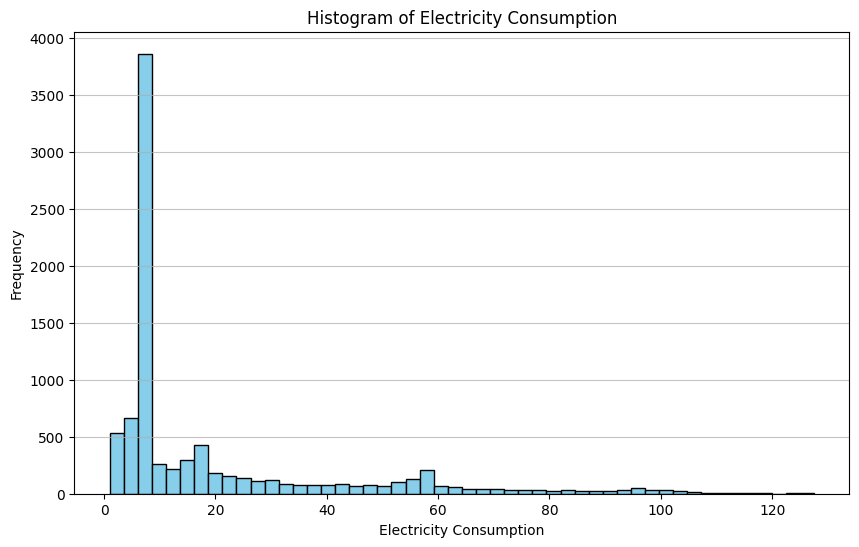

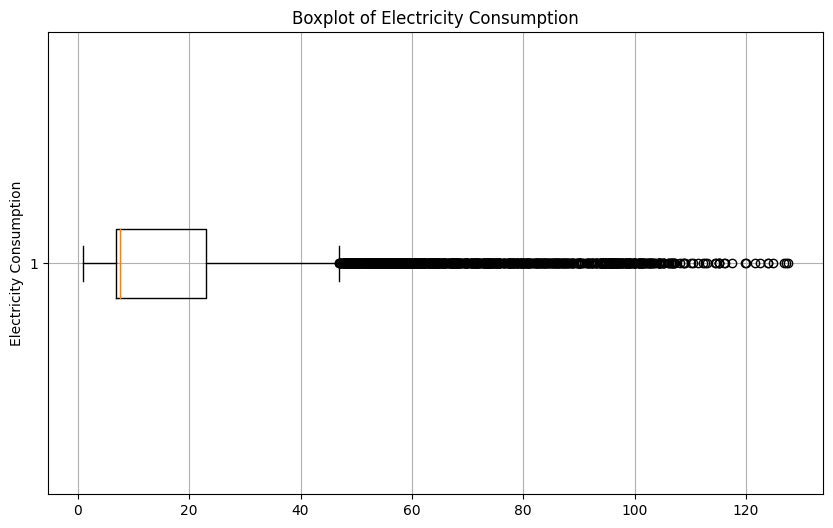

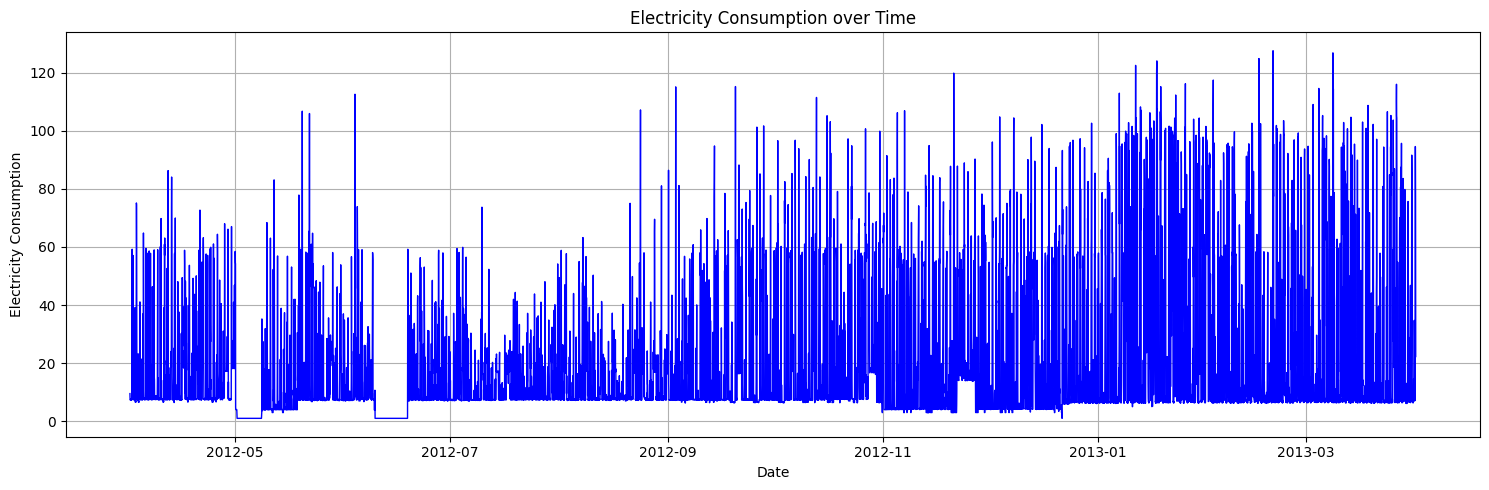

<ipython-input-85-88782fb20406>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['day_of_week'] = df_year.index.dayofweek


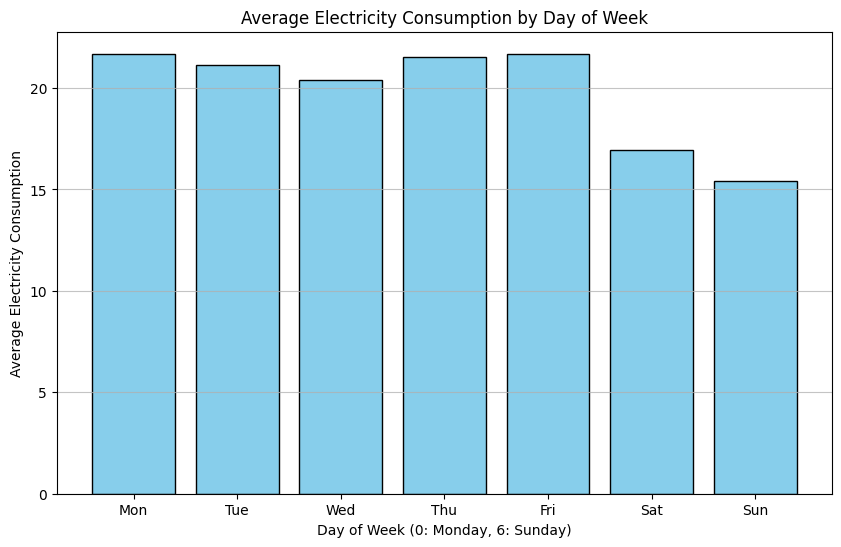

<ipython-input-85-88782fb20406>:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['hour'] = df_year.index.hour


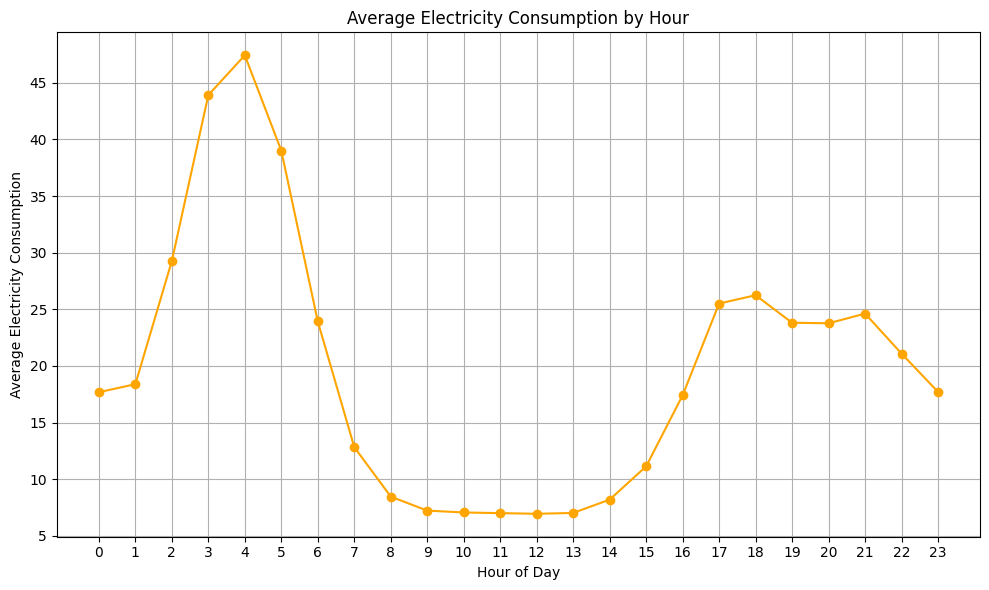

In [85]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. 결측치 확인
# 'df_year' DataFrame에서 각 컬럼의 결측치 개수를 계산
missing_values = df_year.isnull().sum()
print("결측치 개수:")
print(missing_values)

# 2. 0값 확인
# 'df_year' DataFrame에서 각 컬럼의 0값 개수를 계산
zero_values = (df_year == 0).sum()
print("\n0값 개수:")
print(zero_values)

# 3. 데이터 통계량 확인
# 'df_year' DataFrame의 기초 통계량을 출력
print("\n데이터 통계량:")
print(df_year.describe())

# 4. 히스토그램으로 데이터 분포 확인
plt.figure(figsize=(10, 6))
plt.hist(df_year['P'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Electricity Consumption')
plt.ylabel('Frequency')
plt.title('Histogram of Electricity Consumption')
plt.grid(axis='y', alpha=0.75)
plt.show()

# 5. 상자 그림으로 이상치 확인
plt.figure(figsize=(10, 6))
plt.boxplot(df_year['P'], vert=False)
plt.ylabel('Electricity Consumption')
plt.title('Boxplot of Electricity Consumption')
plt.grid(True)
plt.show()

# 6. 시간에 따른 전력 소비량 변화 시각화
plt.figure(figsize=(15, 5))
plt.plot(df_year.index, df_year['P'], color='blue', linewidth=1)
plt.xlabel('Date')
plt.ylabel('Electricity Consumption')
plt.title('Electricity Consumption over Time')
plt.grid(True)
plt.tight_layout()
plt.show()

# 7. 요일별 전력 소비량 평균 비교
# 'day_of_week' 컬럼 추가 (0: Monday, 6: Sunday)
df_year['day_of_week'] = df_year.index.dayofweek

# 요일별 평균 전력 소비량 계산
mean_consumption_by_day = df_year.groupby('day_of_week')['P'].mean()

plt.figure(figsize=(10, 6))
plt.bar(mean_consumption_by_day.index, mean_consumption_by_day.values, color='skyblue', edgecolor='black')
plt.xlabel('Day of Week (0: Monday, 6: Sunday)')
plt.ylabel('Average Electricity Consumption')
plt.title('Average Electricity Consumption by Day of Week')
plt.xticks(mean_consumption_by_day.index,
           ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.grid(axis='y', alpha=0.75)
plt.show()

# 8. 시간대별 전력 소비량 평균 비교
# 'hour' 컬럼 추가 (0-23)
df_year['hour'] = df_year.index.hour

# 시간대별 평균 전력 소비량 계산
mean_consumption_by_hour = df_year.groupby('hour')['P'].mean()

plt.figure(figsize=(10, 6))
plt.plot(mean_consumption_by_hour.index, mean_consumption_by_hour.values, marker='o', linestyle='-', color='orange')
plt.xlabel('Hour of Day')
plt.ylabel('Average Electricity Consumption')
plt.title('Average Electricity Consumption by Hour')
plt.xticks(range(0, 24))  # x축을 0-23 시로 설정
plt.grid(True)
plt.tight_layout()
plt.show()


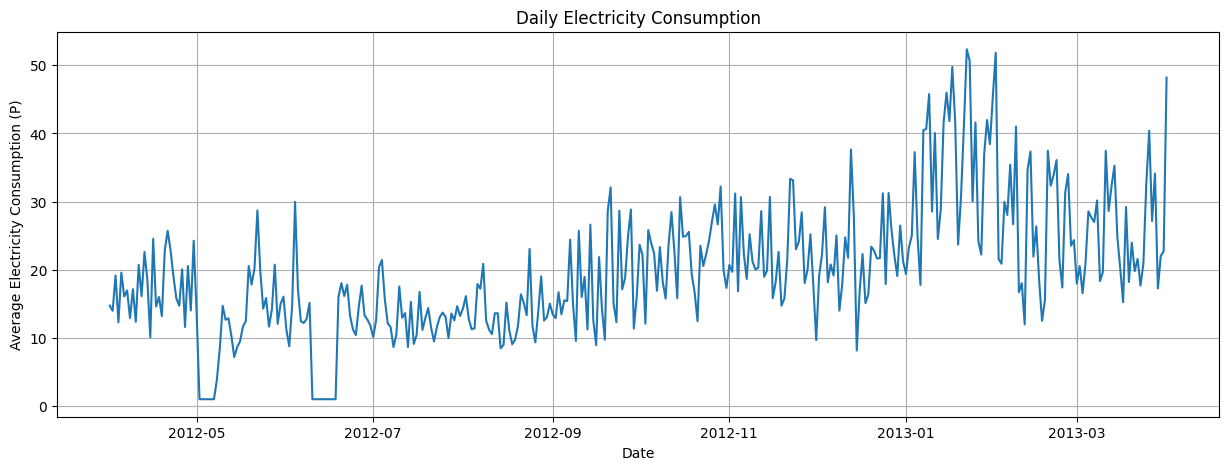

In [86]:
import matplotlib.pyplot as plt
# 하루 단위로 데이터 샘플링
df_daily = df_year.resample('D').mean()

# 하루 단위 데이터 시각화
plt.figure(figsize=(15, 5))
plt.plot(df_daily['P'])
plt.title('Daily Electricity Consumption')
plt.xlabel('Date')
plt.ylabel('Average Electricity Consumption (P)')
plt.grid(True)
plt.show()


In [87]:
# prompt: csv파일 형태로 drive에 저장하기

df_year.to_csv('/content/drive/MyDrive/Colab Notebooks/data/Electricity_B2E_processed.csv')
